### Visualisation of the cause-effect network

In [1]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os

dataPath = "network_predictions"
csv_files = glob.glob(os.path.join(dataPath, "*.csv"))

In [2]:
for file in csv_files:
    data = pd.read_csv(file, sep=";")
    
data = pd.concat([pd.read_csv(file, sep=";") for file in csv_files])
print(data.shape)
data.head()

(149798, 12)


,Unnamed: 0,text,tokenized,io_tags,causes,effects,causes_prep,causes_lemma,effects_prep,effects_lemma,cluster_cause,cluster_effect
0,98000,If anything gestational diabetes has just made...,['If' 'anything' 'gestational' 'diabetes' 'has...,['O' 'O' 'I-C' 'I-C' 'O' 'O' 'O' 'O' 'O' 'I-E'...,"gestational,diabetes","considerate,of,the,food",['gestational'],"['gestational', 'diabete']","['considerate', 'food']","['considerate', 'food']",gestational diabetes,nutrition
1,98001,If anything gestational diabetes has just made...,['If' 'anything' 'gestational' 'diabetes' 'has...,['O' 'O' 'I-C' 'I-C' 'O' 'O' 'O' 'O' 'O' 'I-E'...,"gestational,diabetes",hate,['gestational'],"['gestational', 'diabete']",['hate'],['hate'],gestational diabetes,anger
2,98002,CBD oil really works well I am a type II diabe...,['CBD' 'oil' 'really' 'works' 'well' 'I' 'am' ...,['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'I-C' 'I-C' '...,"type,II,diabetic","inflammation,running,threw,my,body","['type', 'II']","['type', 'II', 'diabetic']","['inflammation', 'running', 'threw', 'body']","['inflammation', 'run', 'throw', 'body']",T1D,infection
3,98003,CBD oil really works well I am a type II diabe...,['CBD' 'oil' 'really' 'works' 'well' 'I' 'am' ...,['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'I-C' 'I-C' '...,"type,II,diabetic","control,my,sugar,levels","['type', 'II']","['type', 'II', 'diabetic']","['control', 'sugar', 'levels']","['control', 'sugar', 'level']",T1D,hypo
4,98004,:new_moon: daughter with type 1 diabetes mysel...,[':new_moon:' 'daughter' 'with' 'type' '1' 'di...,['O' 'O' 'O' 'I-C' 'I-C' 'I-C' 'O' 'O' 'O' 'O'...,"type,1,diabetes",worry,"['type', '1']","['type', '1', 'diabetes']",['worry'],['worry'],T1D,fear


In [3]:
all_clusters = pd.read_csv("/Users/adrianahne/PhD/causality/Causal-associations-diabetes-twitter/data/Causes_effects_clusters - automatically derived.csv")
all_clusters = all_clusters[["Parent class","Parent name", "Cluster name", "Synonyms"]]
print(all_clusters.shape)
all_clusters.head(3)

(1751, 4)


,Parent class,Parent name,Cluster name,Synonyms
0,1,Diabetes,diabetes,"diabetic, #diabetic, #diabetes, diabetes melli..."
1,1,Diabetes,reverse diabetes,"reversed, cured overnight\n"
2,1,Diabetes,T1D,"type 1 diabetes, type 1, #type1, #type1diabete..."


In [7]:
nodes = pd.Series(data["cluster_cause"].values.tolist() + data["cluster_effect"].values.tolist()).value_counts().reset_index()
nodes["name"] = nodes["index"]
nodes["nodesize"] = nodes[0]
#nodes["group"] = 1
del nodes["index"]
del nodes[0]
nodes = pd.merge(nodes, all_clusters, left_on="name", right_on="Cluster name")
del nodes["Cluster name"]
nodes.rename(columns={"Parent class" : "parentClass", "Parent name" : "parentName"}, inplace=True)
print(nodes.shape)
print("N nodes with count 1:")
print(nodes[nodes["nodesize"] <= 5 ].shape)
nodes.head(3)

(1749, 5)
N nodes with count 1:
(757, 5)


,name,nodesize,parentClass,parentName,Synonyms
0,diabetes,67912,1,Diabetes,"diabetic, #diabetic, #diabetes, diabetes melli..."
1,death,17072,8,Death,"die, passed away, gave life, kill, killing, de..."
2,insulin,14389,2,Insulin,"insulin hormone, supplies, HUMALOG bottle\n"


In [8]:
links = data[["cluster_cause", "cluster_effect"]]
links = links.groupby(['cluster_cause','cluster_effect'], as_index=False).size()
links.rename(columns={"cluster_cause":"source", "cluster_effect":"target", "size":"value"}, inplace=True)
print(links.shape)
links.head(10)

(18254, 3)


,source,target,value
0,#340b program,access insulin,1
1,#340b program,death,2
2,#340b program,diet,1
3,#340b program,punching bag,1
4,#340b program,reduce weight,1
5,#340b program,reverse diabetes,1
6,#340b program,sadness,1
7,#340b program,sick,1
8,#340b program,surgeon excited,1
9,#ATouchOfSugarFilm #Diabetes,death,1


In [9]:
############### Take only nodes (and links) with a minimal number of causes/effects associated to them
# & prepare for the visualisation in D3 ################

def nodes_links_minN(nodes, links, minNodes=5, minWeightLinks=5, return_without_diabetes=False):
    reduced_nodes = nodes[nodes["nodesize"] >= minNodes]
    ejected_nodes = nodes[nodes["nodesize"] < minNodes]
    
    reduced_links = links[(links["source"].isin(reduced_nodes["name"])) 
                          & (links["target"].isin(reduced_nodes["name"]))]
    reduced_links = reduced_links[reduced_links["value"] >= minWeightLinks]
    
    reduced_links = reduced_links[reduced_links["source"] != reduced_links["target"]] # ignore if source and target are the same
    
    reduced_nodes = reduced_nodes[(reduced_nodes["name"].isin(links["source"])) | (reduced_nodes["name"].isin(links["target"]))]
        
    if return_without_diabetes:
        reduced_nodes_wo_diabetes = reduced_nodes[reduced_nodes["name"] != "diabetes"]
        reduced_links_wo_diabetes = reduced_links[(reduced_links["source"] != "diabetes") & (reduced_links["target"] != "diabetes")]
        return reduced_nodes, reduced_links, reduced_nodes_wo_diabetes, reduced_links_wo_diabetes
    return reduced_nodes, reduced_links

In [10]:
minNnodes = 10
minNedges = 10
print("nodes:", nodes.shape)
print("links:", links.shape)
reduced_nodes, reduced_links, reduced_nodes_wo_diabetes, reduced_links_wo_diabetes = nodes_links_minN(nodes,links, minNnodes, minNedges, True)
print("reduced_nodes:", reduced_nodes.shape)
print("reduced_links:", reduced_links.shape)
print("reduced_nodes_wo_diabetes:", reduced_nodes_wo_diabetes.shape)
print("reduced_links_wo_diabetes:", reduced_links_wo_diabetes.shape)

# only nodes and edges related to the node "diabetes"
reduced_links_diab = reduced_links[(reduced_links["source"] == "diabetes") | (reduced_links["target"] == "diabetes")]
reduced_nodes_diab = reduced_nodes[(reduced_nodes["name"].isin(reduced_links["source"]) | reduced_nodes["name"].isin(reduced_links["target"]))]
print("reduced_nodes_diab:", reduced_nodes_diab.shape)
print("reduced_links_diab:", reduced_links_diab.shape)


nodes: (1749, 5)
links: (18254, 3)
reduced_nodes: (763, 5)
reduced_links: (1521, 3)
reduced_nodes_wo_diabetes: (762, 5)
reduced_links_wo_diabetes: (1136, 3)
reduced_nodes_diab: (377, 5)
reduced_links_diab: (385, 3)


In [8]:
output = {"nodes": reduced_nodes.to_dict(orient="records")
         , "links": reduced_links.to_dict(orient="records")}
with open('cause_effect_nodes_links_reduced_minNnodes_{}_minNedges_{}.json'.format(minNnodes, minNedges), 'w') as f:
    json.dump(output, f)
output

{'nodes': [{'name': 'diabetes',
   'nodesize': 67912,
   'parentClass': 1,
   'parentName': 'Diabetes',
   'Synonyms': 'diabetic, #diabetic, #diabetes, diabetes mellitus, diabetics, DIABETIC, #Diabetic'},
  {'name': 'death',
   'nodesize': 17072,
   'parentClass': 8,
   'parentName': 'Death',
   'Synonyms': 'die, passed away, gave life, kill, killing, dead, shorter lifespan, loose live, DIED, DIE, DIES, DEAD, DYING, commit suicide, losing father, KILL'},
  {'name': 'insulin',
   'nodesize': 14389,
   'parentClass': 2,
   'parentName': 'Insulin',
   'Synonyms': 'insulin hormone, supplies, HUMALOG bottle\n'},
  {'name': 'T1D',
   'nodesize': 11914,
   'parentClass': 1,
   'parentName': 'Diabetes',
   'Synonyms': 'type 1 diabetes, type 1, #type1, #type1diabetes, T1 diabetic, #Type1, juvenile diabetes'},
  {'name': 'fear',
   'nodesize': 10226,
   'parentClass': 7,
   'parentName': 'Emotions',
   'Synonyms': 'anxiety, terrified, scared, anxious, worries, concern, dread, scary, worried, ner

In [9]:
output_diab = {"nodes": reduced_nodes_diab.to_dict(orient="records")
         , "links": reduced_links_diab.to_dict(orient="records")}
with open('cause_effect_nodes_links_reduced_diabetes_{}_minNedges_{}.json'.format(minNnodes, minNedges), 'w') as f:
    json.dump(output_diab, f)
output

{'nodes': [{'name': 'diabetes',
   'nodesize': 67912,
   'parentClass': 1,
   'parentName': 'Diabetes',
   'Synonyms': 'diabetic, #diabetic, #diabetes, diabetes mellitus, diabetics, DIABETIC, #Diabetic'},
  {'name': 'death',
   'nodesize': 17072,
   'parentClass': 8,
   'parentName': 'Death',
   'Synonyms': 'die, passed away, gave life, kill, killing, dead, shorter lifespan, loose live, DIED, DIE, DIES, DEAD, DYING, commit suicide, losing father, KILL'},
  {'name': 'insulin',
   'nodesize': 14389,
   'parentClass': 2,
   'parentName': 'Insulin',
   'Synonyms': 'insulin hormone, supplies, HUMALOG bottle\n'},
  {'name': 'T1D',
   'nodesize': 11914,
   'parentClass': 1,
   'parentName': 'Diabetes',
   'Synonyms': 'type 1 diabetes, type 1, #type1, #type1diabetes, T1 diabetic, #Type1, juvenile diabetes'},
  {'name': 'fear',
   'nodesize': 10226,
   'parentClass': 7,
   'parentName': 'Emotions',
   'Synonyms': 'anxiety, terrified, scared, anxious, worries, concern, dread, scary, worried, ner

In [33]:
output_wo_diab = {"nodes": reduced_nodes_wo_diabetes.to_dict(orient="records")
         , "links": reduced_links_wo_diabetes.to_dict(orient="records")}
with open('cause_effect_nodes_links_reduced_wo_diabetes_{}_minNedges_{}.json'.format(minNnodes, minNedges), 'w') as f:
    json.dump(output_wo_diab, f)
output

{'nodes': [{'name': 'diabetes',
   'nodesize': 67912,
   'parentClass': 1,
   'parentName': 'Diabetes'},
  {'name': 'death',
   'nodesize': 17072,
   'parentClass': 8,
   'parentName': 'Death'},
  {'name': 'insulin',
   'nodesize': 14389,
   'parentClass': 2,
   'parentName': 'Insulin'},
  {'name': 'T1D',
   'nodesize': 11914,
   'parentClass': 1,
   'parentName': 'Diabetes'},
  {'name': 'fear',
   'nodesize': 10226,
   'parentClass': 7,
   'parentName': 'Emotions'},
  {'name': 'hypo',
   'nodesize': 9688,
   'parentClass': 10,
   'parentName': 'Glycemic variability'},
  {'name': 'sick',
   'nodesize': 6597,
   'parentClass': 13,
   'parentName': 'Symptoms'},
  {'name': 'overweight',
   'nodesize': 5225,
   'parentClass': 12,
   'parentName': 'Nutrition'},
  {'name': 'T2D',
   'nodesize': 4999,
   'parentClass': 1,
   'parentName': 'Diabetes'},
  {'name': 'neuropathy',
   'nodesize': 4513,
   'parentClass': 3,
   'parentName': 'Complications & comorbidities'},
  {'name': 'medication',


In [34]:
reduced_nodes#, reduced_links
reduced_nodes.shape

(763, 4)

In [35]:
nodes[0:30].parentName.value_counts()

Nutrition                        6
Diabetes                         4
Insulin                          3
Emotions                         3
Healthcare system                3
Glycemic variability             2
Health                           2
Diabetes Distress                2
Death                            1
Symptoms                         1
Complications & comorbidities    1
Diabetes Technology              1
Blood pressure                   1
Name: parentName, dtype: int64

In [36]:
nodes.head(30)

,name,nodesize,parentClass,parentName
0,diabetes,67912,1,Diabetes
1,death,17072,8,Death
2,insulin,14389,2,Insulin
3,T1D,11914,1,Diabetes
4,fear,10226,7,Emotions
5,hypo,9688,10,Glycemic variability
6,sick,6597,13,Symptoms
7,overweight,5225,12,Nutrition
8,T2D,4999,1,Diabetes
9,neuropathy,4513,3,Complications & comorbidities


In [100]:
links.sort_values(by="value", ascending=False).head(39)

,source,target,value
5369,diabetes,death,7446
5495,diabetes,fear,4836
6048,diabetes,sick,2799
5809,diabetes,neuropathy,2477
5624,diabetes,hypo,2062
5149,diabetes,anger,1908
6130,diabetes,suffer,1808
5650,diabetes,insulin,1605
5842,diabetes,overweight,1506
5961,diabetes,reduce weight,1487


In [101]:
links[(links["target"] == "diabetes") & (links["value"] > 10)]

,source,target,value
719,OGTT,diabetes,16
1354,T1D,diabetes,57
1999,T2D,diabetes,21
5393,diabetes,diabetes,60
6523,diet,diabetes,79
6952,eating healthy,diabetes,12
7366,fasting,diabetes,68
7829,finance,diabetes,13
8202,genetic,diabetes,15
8342,gestational diabetes,diabetes,11


In [11]:
sorted_links = links.sort_values(by="value", ascending=False)
sorted_links = sorted_links[sorted_links["source"] != "diabetes"][0:31]
sorted_links

,source,target,value
17793,unable to afford insulin,death,1246
11037,insulin,death,1156
1410,T1D,fear,1054
1338,T1D,death,999
15516,rationing insulin,death,805
1504,T1D,insulin,751
874,OGTT,sick,584
1486,T1D,hypo,578
11179,insulin,hypo,545
11103,insulin,fear,534


<Figure size 1008x432 with 0 Axes>

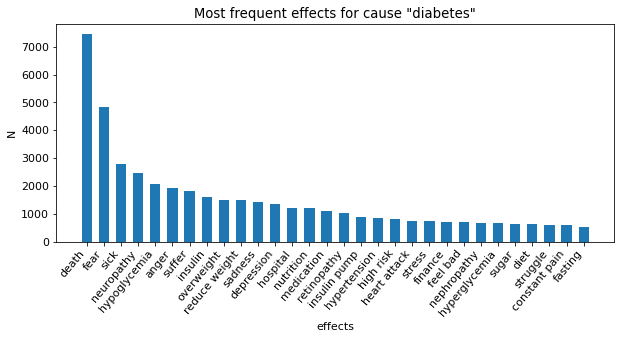

In [18]:
sorted_links = links.sort_values(by="value", ascending=False)
sorted_links = sorted_links[sorted_links["source"] == "diabetes"][0:30]
data = sorted_links.value.values.tolist()
labels = sorted_links.target.values.tolist()
labels[labels.index("hypo")] = "hypoglycemia"
labels[labels.index("hyperglycemic")] = "hyperglycemia"
#labels = ['A', 'B', 'C', 'D', 'E'
plt.figure(figsize=(14,6))
fig, ax = plt.subplots()
fig.set_figwidth(10)
#plt.xticks(np.linspace(0, (len(data)-1)*2, len(data)), labels, rotation=50)
ax.set_xticks(range(len(data)))
ax.set_xticklabels(labels, rotation = 50, ha="right")
plt.xlabel('effects')
plt.ylabel('N')
plt.title('Most frequent effects for cause "diabetes"')
plt.bar(range(len(data)), data, width=0.6, align="center") 
plt.savefig("most_frequent_effects_for_cause_diabetes_smaller.png", bbox_inches='tight', dpi=138)
plt.rcParams.update({'font.size': 11})
plt.show()

In [129]:
range(len(data)*2,)

range(0, 60)

In [130]:
labels

['death',
 'fear',
 'sick',
 'neuropathy',
 'hypoglycemia',
 'anger',
 'suffer',
 'insulin',
 'overweight',
 'reduce weight',
 'sadness',
 'depression',
 'hospital',
 'nutrition',
 'medication',
 'retinopathy',
 'insulin pump',
 'hypertension',
 'high risk',
 'heart attack',
 'stress',
 'finance',
 'feel bad',
 'nephropathy',
 'hyperglycemia',
 'sugar',
 'diet',
 'struggle',
 'constant pain',
 'fasting']

In [132]:
#labels[labels.index("hypo")] = "hypoglycemia"
#labels[labels.index("hyperglycemic")] = "hyperglycemia"

labels

['death',
 'fear',
 'sick',
 'neuropathy',
 'hypoglycemia',
 'anger',
 'suffer',
 'insulin',
 'overweight',
 'reduce weight',
 'sadness',
 'depression',
 'hospital',
 'nutrition',
 'medication',
 'retinopathy',
 'insulin pump',
 'hypertension',
 'high risk',
 'heart attack',
 'stress',
 'finance',
 'feel bad',
 'nephropathy',
 'hyperglycemia',
 'sugar',
 'diet',
 'struggle',
 'constant pain',
 'fasting']

In [133]:
all_clusters[all_clusters["Cluster name"].isin(labels)]["Parent name"].value_counts()

Nutrition                        6
Complications & comorbidities    5
Healthcare system                3
Emotions                         3
Diabetes Distress                3
Other                            2
Diabetes                         1
Insulin                          1
Death                            1
Diabetes Technology              1
Blood pressure                   1
Symptoms                         1
Name: Parent name, dtype: int64

In [20]:
sample = data[["text", "causes", "effects", "cluster_cause", "cluster_effect"]]
sample = data[(data["cluster_cause"] == "death") | (data["cluster_effect"] == "death")]
for i, row in sample.sample(n=30).iterrows():
    print("\ncause: {} ({});\teffect: {} ({})".format(row["causes"], row["cluster_cause"], row["effects"], row["cluster_effect"]))
    print(row["text"])


cause: diabetes (diabetes);	effect: killed (death)
I have never had diabetes , but it killed my Mom and her brother so I 've always been concerned .

cause: Complications,from,that,darn,diabetes (complications);	effect: death (death)
Complications from that darn diabetes was also a contributing factor in the death of Mickey Rooney .

cause: diabetes (diabetes);	effect: died (death)
@USER @USER He died because he did n't get sent to his death , he died from diabetes , he was a criminal , too bad he died , but his own fault .

cause: diabetes (diabetes);	effect: dying (death)
I do n't even know how many times I thought I had cancer , diabetes or just dying .

cause: corona (covid);	effect: die (death)
@USER No one who is not old or veey sick like cancer diabetes od something will die on corona

cause: high,glucose,numbers (hyperglycemic);	effect: death (death)
@USER As a 43 year survivor of type 1 , this young mans death with extended high glucose numbers is a wretched way to pass .

ca

## Get sorted list of 100 most important clusters

In [121]:
minNnodes = 10
minNedges = 10
print("nodes:", nodes.shape)
print("links:", links.shape)
reduced_nodes, reduced_links, reduced_nodes_wo_diabetes, reduced_links_wo_diabetes = nodes_links_minN(nodes,links, minNnodes, minNedges, True)
print("reduced_nodes:", reduced_nodes.shape)
print("reduced_links:", reduced_links.shape)
reduced_nodes.head(2)

nodes: (1749, 5)
links: (18254, 3)
reduced_nodes: (763, 5)
reduced_links: (1521, 3)


,name,nodesize,parentClass,parentName,Synonyms
0,diabetes,67912,1,Diabetes,"diabetic, #diabetic, #diabetes, diabetes melli..."
1,death,17072,8,Death,"die, passed away, gave life, kill, killing, de..."


In [123]:
reduced_data = data[(data["cluster_cause"].isin(reduced_nodes["name"])) & (data["cluster_effect"].isin(reduced_nodes["name"]))]
print(data.shape)
print(reduced_data.shape)
reduced_nodes_count= pd.Series(reduced_data["cluster_cause"].values.tolist() + reduced_data["cluster_effect"].values.tolist()).value_counts().reset_index()
print(reduced_nodes_count.shape)
reduced_nodes_count["name"] = reduced_nodes_count["index"]
reduced_nodes_count["nodesize"] = reduced_nodes_count[0]
#nodes["group"] = 1
del reduced_nodes_count["index"]
del reduced_nodes_count[0]
reduced_nodes_count.head()


(149798, 12)
(146087, 12)
(763, 2)


,name,nodesize
0,diabetes,66775
1,death,16989
2,insulin,14148
3,T1D,11693
4,fear,10160


In [126]:
merge = pd.merge(reduced_nodes_count, all_clusters, left_on="name", right_on="Cluster name")
print(merge.shape)
merge.head(3)

(763, 6)


,name,nodesize,Parent class,Parent name,Cluster name,Synonyms
0,diabetes,66775,1,Diabetes,diabetes,"diabetic, #diabetic, #diabetes, diabetes melli..."
1,death,16989,8,Death,death,"die, passed away, gave life, kill, killing, de..."
2,insulin,14148,2,Insulin,insulin,"insulin hormone, supplies, HUMALOG bottle\n"


In [127]:
merge.to_csv("sorted_clusters_with_synonyms.csv")

## Check most frequent causes/effects for DD related terms

In [3]:
import json
import pandas as pd 
#data = pd.read_json("cause_effect_nodes_links_reduced_wo_diabetes_10_minNedges_10.json", orient="index")
#data.head()
data = json.load(open("cause_effect_nodes_links_reduced_wo_diabetes_10_minNedges_10.json", "r"))
data = pd.DataFrame(data["links"])
data.head()

,source,target,value
0,DMV problems $ $ $,insulin,11
1,OGTT,Coffee,14
2,OGTT,Insomnia,39
3,OGTT,acquired taste,19
4,OGTT,anger,162


In [32]:
concept = "suffer"
data[data["source"] == concept].sort_values(by="value", ascending=False).head(10)

,source,target,value


In [33]:
data[data["target"] == concept].sort_values(by="value", ascending=False).head(10)

,source,target,value
155,T1D,suffer,201
554,hypertension,suffer,136
714,insulin,suffer,106
227,T2D,suffer,81
963,overweight,suffer,56
426,finance,suffer,45
608,hypo,suffer,41
1134,unable to afford insulin,suffer,38
853,medication,suffer,36
1039,rationing insulin,suffer,27


In [34]:
tt = ""
for i, row in data[data["target"] == concept].sort_values(by="value", ascending=False).head(10).iterrows():
    #print(row["source"], row["value"])
    tt += row["source"] + " (" + str(row["value"]) + "), "
tt

'T1D (201), hypertension (136), insulin (106), T2D (81), overweight (56), finance (45), hypo (41), unable to afford insulin (38), medication (36), rationing insulin (27), '

In [39]:
for i, row in data[data["value"] < 60].sort_values(by="value", ascending=False).head(400).iterrows():
    print(row["source"], "\t -> ", row["target"], "  :", row["value"])

T2D 	 ->  sugar   : 59
complications 	 ->  neuropathy   : 59
diet 	 ->  insulin resistance   : 59
prediabetes 	 ->  death   : 59
stress 	 ->  hyperglycemic   : 58
overweight 	 ->  high risk   : 58
insulin 	 ->  diabetic ketoacidosis   : 58
insulin resistance 	 ->  reduce weight   : 57
sugar 	 ->  hypo   : 57
sugar 	 ->  death   : 57
T1D 	 ->  overweight   : 57
overweight 	 ->  insulin   : 57
overweight 	 ->  depression   : 57
continuous glucose monitor 	 ->  hypo   : 57
overweight 	 ->  suffer   : 56
insulin 	 ->  sugar   : 55
insulin pump 	 ->  continuous glucose monitor   : 55
sugar 	 ->  sick   : 55
hypo 	 ->  reduce weight   : 55
insulin 	 ->  rationing insulin   : 54
hypertension 	 ->  cholesterol   : 54
insulin 	 ->  Insomnia   : 54
prediabetes 	 ->  hypertension   : 54
hypo 	 ->  joy   : 54
unable to afford insulin 	 ->  finance   : 53
stress 	 ->  insulin   : 53
insulin resistance 	 ->  sick   : 53
insulin 	 ->  fasting   : 53
hypo 	 ->  stress   : 52
medication 	 ->  finance  

In [38]:
fodata.sort_values(by="value", ascending=False).head(1000)

,source,target,value
1113,unable to afford insulin,death,1246
650,insulin,death,1156
89,T1D,fear,1054
79,T1D,death,999
1024,rationing insulin,death,805
...,...,...,...
403,fibromyalgia,neuropathy,11
875,neuropathy,infection,11
876,neuropathy,joy,11
400,fibromyalgia,constant pain,11
